In [301]:
%load_ext autoreload
%autoreload 2
from common import *
from envs import *
from copy import deepcopy
from RiskAverseMCTS import RiskAverseMCTS
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
N_alpha = 6
N_params = 2
N_rollouts = 50
N_iter = 1000
alpha_vals = np.linspace(0.5,1.0,N_alpha)
param_vals = np.arange(N_params)
mdps = [MultiArmedBandit(param=p) for p in param_vals]
rewards = np.zeros([N_alpha, N_params, N_rollouts])
belief = np.ones(N_params, dtype='float')/N_params

In [223]:
agent = RiskAverseMCTS(mdps, belief, max_depth=12, alpha=1.0, max_r=2., n_iter=N_iter )

In [24]:
import cProfile

In [69]:
cProfile.run("env.rollout(n_rollouts=1, render=False)")

         7146463 function calls (7083461 primitive calls) in 8.489 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.551    8.551 <string>:1(<module>)
      501    0.000    0.000    0.001    0.000 <string>:12(__new__)
        1    0.000    0.000    0.000    0.000 <string>:2(<module>)
       12    0.000    0.000    0.000    0.000 <string>:2(_parse_args)
       10    0.000    0.000    0.000    0.000 <string>:5(_parse_args_rvs)
      500    0.025    0.000    1.604    0.003 RiskAverseMCTS.py:113(update_adversarial_belief)
24231/5000    0.269    0.000    6.511    0.001 RiskAverseMCTS.py:143(simulate)
40769/5000    0.192    0.000    3.523    0.001 RiskAverseMCTS.py:173(rollout)
    40769    0.027    0.000    0.245    0.000 RiskAverseMCTS.py:183(sample_rollout_action)
     5836    0.111    0.000    0.111    0.000 RiskAverseMCTS.py:187(ucb_action)
    13407    0.079    0.000    0.328    0.000 RiskAver

In [162]:
env = Env(mdps[1], agent)
stats = env.rollout(n_rollouts=10, render=False)
print(stats.trajectories)

[[[0, 3, 3, 1], [1, 1, 0, 1], [1, 0, -1, 1], [1, 3, -6, 3], [3, 0, 5, 2], [2, 2, -4, 3], [3, 0, 5, 2], [2, 1, 7, 1], [1, 3, -6, 3], [3, 1, 6, 2]], [[0, 3, -13, 3], [3, 1, -2, 3], [3, 0, 5, 2], [2, 0, 6, 1], [1, 2, 5, 1], [1, 3, -6, 3], [3, 0, 13, 1], [1, 3, -6, 3], [3, 0, -3, 3], [3, 0, -3, 3]], [[0, 4, -16, 4], [4, 0, 4, 3], [3, 0, 5, 2], [2, 2, -12, 4], [4, 0, 4, 3], [3, 1, -2, 3], [3, 1, 6, 2], [2, 1, -1, 2], [2, 1, -9, 3], [3, 0, 5, 2]], [[0, 0, 0, -1], [-1, 5, -10, 3], [3, 0, 5, 2], [2, 0, 14, 0], [0, 0, 0, -1], [-1, 0, -11, -3], [-3, 3, -10, -2], [-2, 5, -9, 2], [2, 2, 4, 2], [2, 2, -4, 3]], [[0, 3, -13, 3], [3, 0, 13, 1], [1, 1, -8, 2], [2, 0, 6, 1], [1, 2, -3, 2], [2, 0, 6, 1], [1, 0, 7, 0], [0, 2, -2, 1], [1, 2, -3, 2], [2, 0, -2, 2]], [[0, 3, -5, 2], [2, 0, -2, 2], [2, 0, 6, 1], [1, 0, 7, 0], [0, 3, 3, 1], [1, 2, -3, 2], [2, 1, -1, 2], [2, 0, 6, 1], [1, 2, -3, 2], [2, 1, -9, 3]], [[0, 3, 3, 1], [1, 1, 8, 0], [0, 4, -16, 4], [4, 0, 4, 3], [3, 1, -10, 4], [4, 0, 12, 2], [2, 0, 

In [262]:
for i, alpha in enumerate(alpha_vals):
    for j, mdp in enumerate(mdps):
        agent = RiskAverseMCTS(mdps, belief, max_depth=10, 
                               alpha=alpha, max_r=1., n_iter=N_iter )
        env = Env(mdp, agent)
        stats = env.rollout(n_rollouts=N_rollouts, render=False)
        rewards[i,j,:] = stats.total_rewards
        print("\r a =",alpha,"\tmdp",j,"reward:", np.mean(stats.total_rewards), end='', flush='True')
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.25 	avg_r: 0.35 	var_r: 0.0361
 a = 0.5 	avg_r: 0.32 	var_r: 0.0484
 a = 0.75 	avg_r: 0.41 	var_r: 0.0729
 a = 1.0 	avg_r: 0.41 	var_r: 0.0961


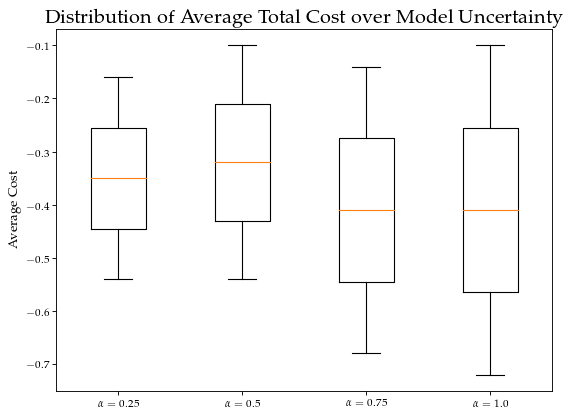

In [263]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.boxplot(np.mean(-rewards[:,:,:], axis=2).T, labels=[r"$\alpha=0.25$", r"$\alpha=0.5$", r"$\alpha=0.75$", r"$\alpha=1.0$"])
plt.title("Distribution of Average Total Cost over Model Uncertainty", fontsize=18)
plt.ylabel("Average Cost", fontsize=12)
#plt.xlabel("Avg Total Cost under Model", fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('performance_gridworld_spreads_5.pdf')
plt.show()

In [115]:
rewards_old[0,:,:] = rewards[0,:,:]

In [101]:
for i, alpha in enumerate(alpha_vals):
    print("\r a =",alpha,"\tavg_r:",np.mean(rewards[i,:,:]), "\tvar_r:", np.var(np.mean(rewards[i,:,:], axis=1)), flush='True')

 a = 0.5 	avg_r: 0.333333333333 	var_r: 0.00111111111111
 a = 0.666666666667 	avg_r: 0.416666666667 	var_r: 0.1225
 a = 0.833333333333 	avg_r: 0.5 	var_r: 0.25
 a = 1.0 	avg_r: 0.5 	var_r: 0.25


In [85]:
np.mean(-rewards[:,:,:], axis=2)

array([[-0.37333333, -0.08333333,  0.10666667, -0.26      ],
       [-0.50666667, -0.49333333, -0.41666667, -0.25666667],
       [-0.56333333, -0.05      , -0.46666667, -0.15666667]])

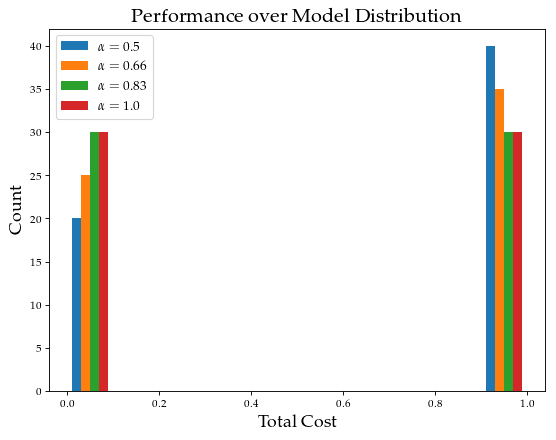

In [100]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(np.reshape(-rewards+1, [4, -1]).T, label=[r"$\alpha=0.5$", r"$\alpha=0.66$", r"$\alpha=0.83$", r"$\alpha=1.0$"])
plt.title("Performance over Model Distribution", fontsize=18)
plt.ylabel("Count", fontsize=16)
plt.xlabel("Total Cost", fontsize=16)
plt.legend(fontsize=12)
plt.savefig('performance_bandit.pdf')
plt.show()

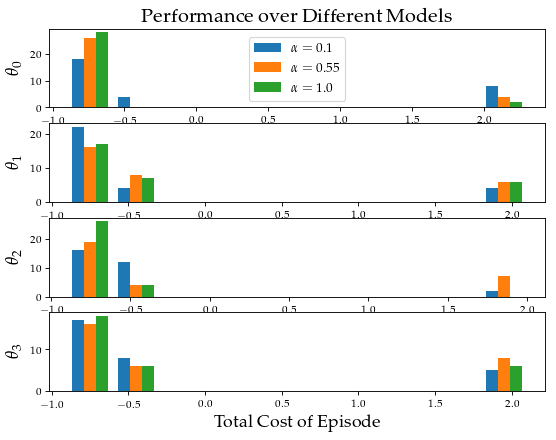

In [95]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in range(N_params):
    plt.subplot(N_params, 1, i+1)
    plt.hist(-old_rewards[:,i,:].T, label=[r"$\alpha=0.1$",r"$\alpha=0.55$", r"$\alpha=1.0$"])
    if i == 0:
        plt.title("Performance over Different Models", fontsize=18)
        plt.legend(fontsize=12)
    plt.ylabel(r"$\theta_"+str(i)+r"$", fontsize=16)
    if i == N_params - 1:
        plt.xlabel("Total Cost of Episode", fontsize=16)
plt.savefig('performance_per_model.pdf')
plt.show()

# Convergence plots

In [308]:
belief_curves = []
agent_value_curves = []
adv_value_curves = []
final_q_vals = []
final_n_vals = []
for i, alpha in enumerate(alpha_vals):
    agent = RiskAverseMCTS(mdps, belief, max_depth=5, 
                               alpha=alpha, max_r=1.5, n_iter=500 )
    s0 = mdps[0].reset()
    agent.MCTS(s0)
    belief_curves.append(deepcopy(agent.adv_dists))
    agent_value_curves.append(deepcopy(agent.agent_est_value))
    adv_value_curves.append(deepcopy(agent.adv_est_value))
    final_q_vals.append( [agent.Qha[(s0,a)] for a in mdps[0].action_space(s0)] )
    final_n_vals.append( [agent.Nha[(s0,a)] for a in mdps[0].action_space(s0)] )

In [309]:
(1 - np.array(final_q_vals)).T

array([[ 0.80810235,  0.82069795,  0.80594059,  0.76638177,  0.81621622,
         0.8490566 ],
       [ 0.80325581,  0.7721943 ,  0.73082707,  0.70172911,  0.68292683,
         0.64358974],
       [ 0.86898396,  0.77434402,  0.71511628,  0.64373464,  0.61520376,
         0.58495822],
       [ 1.        ,  0.83861237,  0.72595156,  0.62612806,  0.57152362,
         0.49207607]])

In [310]:
np.array(final_n_vals).T

array([[1876,  831,  505,  351,  185,  106],
       [2150, 1791, 1330,  694,  533,  390],
       [ 748, 1715, 1720, 1628, 1276,  718],
       [ 226,  663, 1445, 2327, 3006, 3786]])

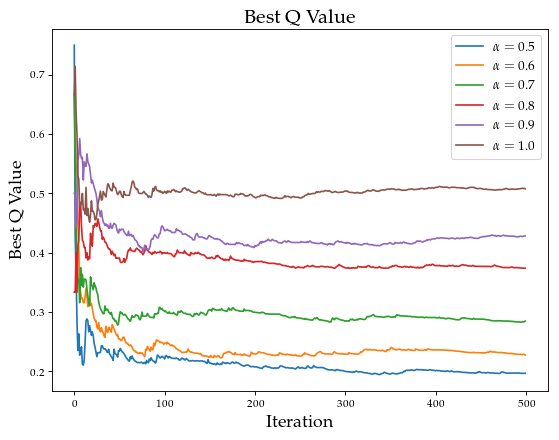

In [311]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate(alpha_vals):
    plt.plot(np.array(agent_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
plt.title("Best Q Value", fontsize=18)
plt.ylabel("Best Q Value", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

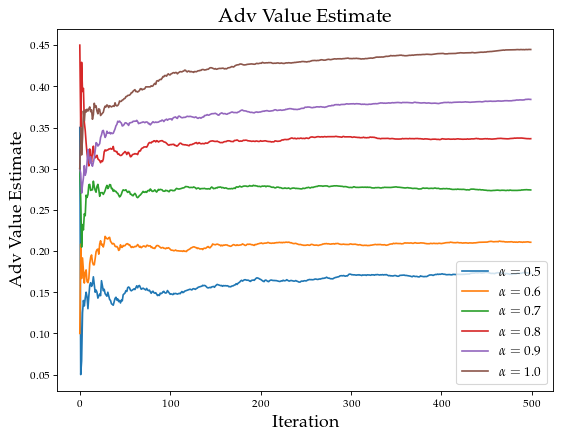

In [312]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i,a in enumerate(alpha_vals):
    plt.plot(np.array(adv_value_curves)[i], label=(r"$\alpha="+str(a)+r"$"))
plt.title("Adv Value Estimate", fontsize=18)
plt.ylabel("Adv Value Estimate", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [217]:
belief_curves = np.array(belief_curves)

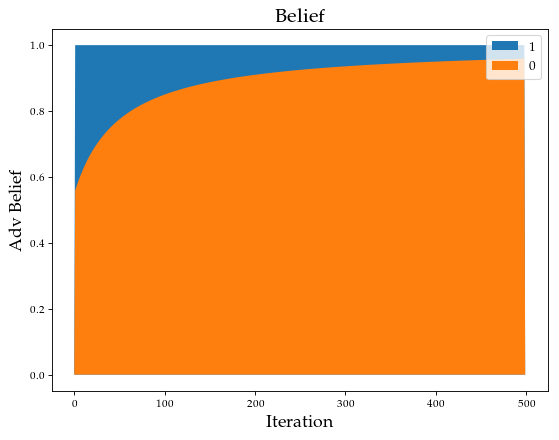

In [299]:
cum_belief_curves = np.cumsum(belief_curves, axis=2)
cum_belief_curves[:,0,:] = 0
cum_belief_curves[:,-1,:] = 0
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
for i in reversed(range(N_params)):
    plt.fill(cum_belief_curves[0,:,i], label=str(i))
plt.title("Belief", fontsize=18)
plt.ylabel("Adv Belief", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [151]:
rewards = np.load('rewards_one.npy')

(3, 4, 30)